In [5]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import shutil
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [6]:
def load_images_with_labels(base_folder, subfolders, target_size=(100, 100), sample_count=5):
    data = []
    labels = []
    count = {}
    sample = {folder: [] for folder in subfolders}
    
    for folder_name in subfolders:
        folder_path = os.path.join(base_folder, folder_name)
        count[folder_name] = 0
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path, cv.IMREAD_COLOR)  
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  
                img = cv.resize(img, target_size)
                data.append(img)
                labels.append(folder_name)
                
                count[folder_name] += 1
                
                if len(sample[folder_name]) < sample_count:
                    sample[folder_name].append(img)
    
    return np.array(data), np.array(labels), count, sample

# Define base folder and subfolders
base_folder = 'Testing'
subfolders = ['fresh_peaches', 'fresh_pomegranates', 'fresh_strawberries', 'rotten_peaches', 'rotten_pomegranates', 'rotten_strawberries']

data, labels, count, sample = load_images_with_labels(base_folder, subfolders)
print(f"Loaded {len(data)} images")

Loaded 600 images


In [7]:
def data_distribution(labels):
    distribution = pd.Series(labels).value_counts()
    return distribution

distribution = data_distribution(labels)
print('Jumlah data:', len(labels))
print('\nDistribusi data per kategori:')
print(distribution.to_string())


Jumlah data: 600

Distribusi data per kategori:
fresh_peaches          100
fresh_pomegranates     100
fresh_strawberries     100
rotten_peaches         100
rotten_pomegranates    100
rotten_strawberries    100


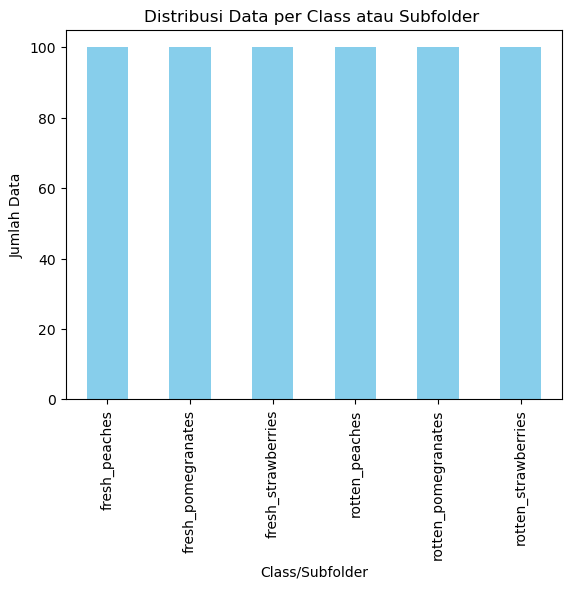

In [8]:
def plot_data_distribution(distribution):
    distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribusi Data per Class atau Subfolder ')
    plt.xlabel('Class/Subfolder')
    plt.ylabel('Jumlah Data')
    plt.show()

plot_data_distribution(distribution)

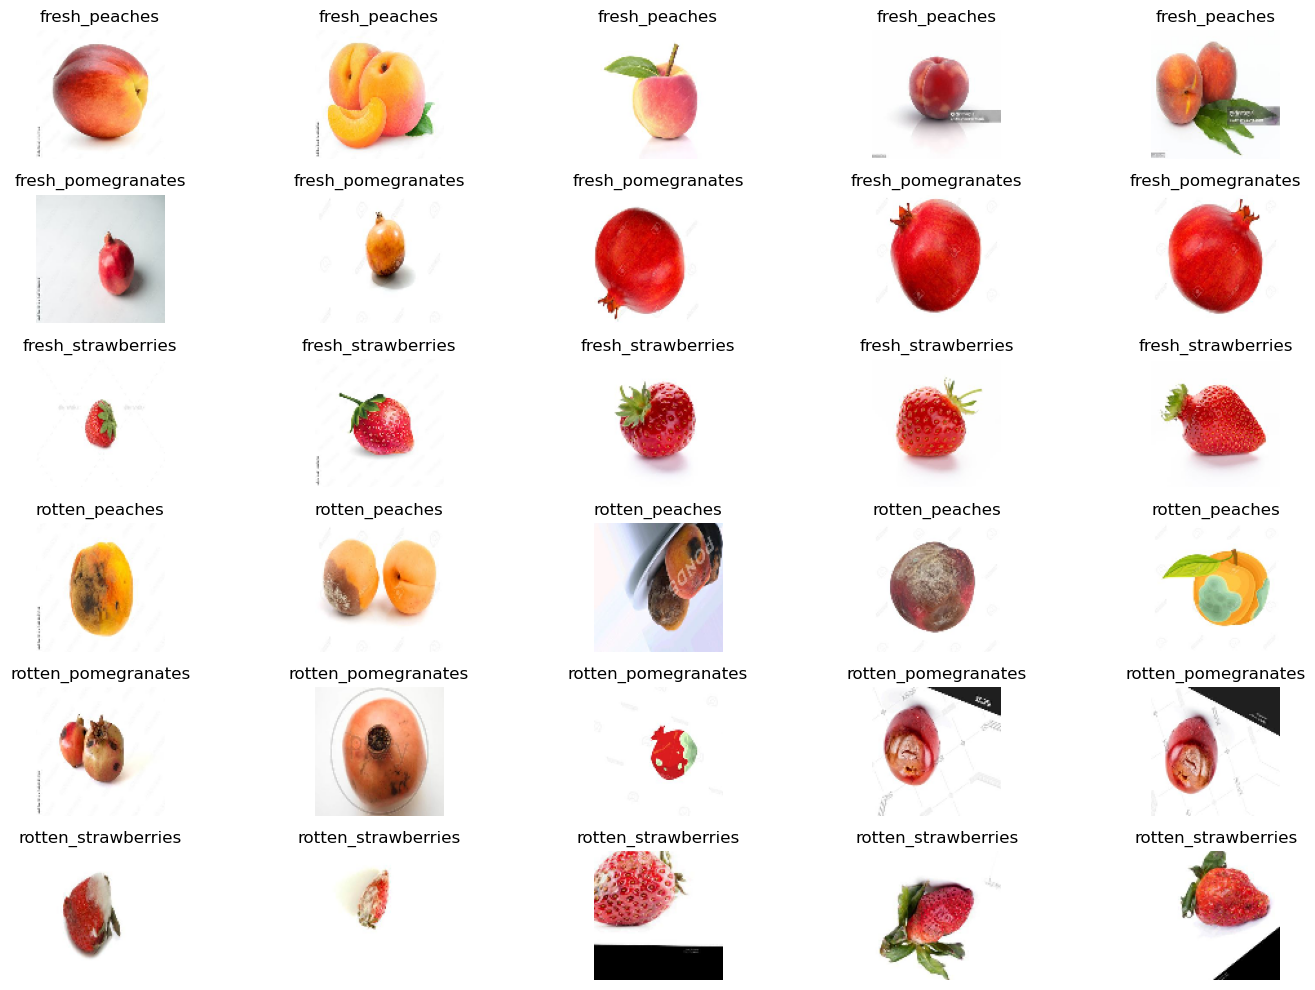

In [30]:
fig, axs = plt.subplots(len(subfolders), 5, figsize=(15, 10))
for i, folder in enumerate(subfolders):
    for j in range(5):
        if j < len(sample[folder]):
            axs[i, j].imshow(sample[folder][j])
            axs[i, j].set_title(f"{folder}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## Augmentasi


In [10]:
def horizontal_flip(img):
    return cv.flip(img, 1)

def rotate_image(img, angle):
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    return cv.warpAffine(img, rotation_matrix, (width, height))

def zoom_image(img, zoom_factor):
    height, width = img.shape[:2]
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    resized_img = cv.resize(img, (new_width, new_height))
    
    if zoom_factor < 1.0:
        pad_height = (height - new_height) // 2
        pad_width = (width - new_width) // 2
        padded_img = cv.copyMakeBorder(resized_img, pad_height, pad_height, pad_width, pad_width, cv.BORDER_CONSTANT, value=0)
        return padded_img[:height, :width]
    else:
        start_y = (new_height - height) // 2
        start_x = (new_width - width) // 2
        return resized_img[start_y:start_y+height, start_x:start_x+width]

def translate_image(img, x_shift, y_shift):
    height, width = img.shape[:2]
    translation_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv.warpAffine(img, translation_matrix, (width, height))

def adjust_brightness(img, factor):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    hsv[:, :, 2] = cv.add(hsv[:, :, 2], factor)
    return cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

In [11]:
augmented_data = []
augmented_labels = []
img_paths = []

base_dir = 'augmented_images'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

for label in set(labels):
    label_dir = os.path.join(base_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

# Loop melalui data dan melakukan augmentasi
for i, (img, label) in enumerate(zip(data, labels)):
    label_dir = os.path.join(base_dir, label)
    
    # Menyimpan gambar asli
    img_path = os.path.join(label_dir, f"{label}_{i}_original.jpg")
    cv.imwrite(img_path, img)
    augmented_data.append(img)
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Horizontal flip
    au1 = horizontal_flip(img)
    img_path = os.path.join(label_dir, f"{label}_{i}_horizontal_flip.jpg")
    cv.imwrite(img_path, au1)
    augmented_data.append(au1)
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Rotate 90 degrees
    au2 = rotate_image(img, 90)
    img_path = os.path.join(label_dir, f"{label}_{i}_rotate_90.jpg")
    cv.imwrite(img_path, au2)
    augmented_data.append(au2)
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Zoom
    au3 = zoom_image(img, 1.2)
    img_path = os.path.join(label_dir, f"{label}_{i}_zoom.jpg")
    cv.imwrite(img_path, au3)
    augmented_data.append(au3)
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Translate
    au4 = translate_image(img, 10, 10)
    img_path = os.path.join(label_dir, f"{label}_{i}_translate.jpg")
    cv.imwrite(img_path, au4)
    augmented_data.append(au4)
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Adjust brightness
    au5 = adjust_brightness(img, 30)
    img_path = os.path.join(label_dir, f"{label}_{i}_brightness.jpg")
    cv.imwrite(img_path, au5)
    augmented_data.append(au5)
    augmented_labels.append(label)
    img_paths.append(img_path)

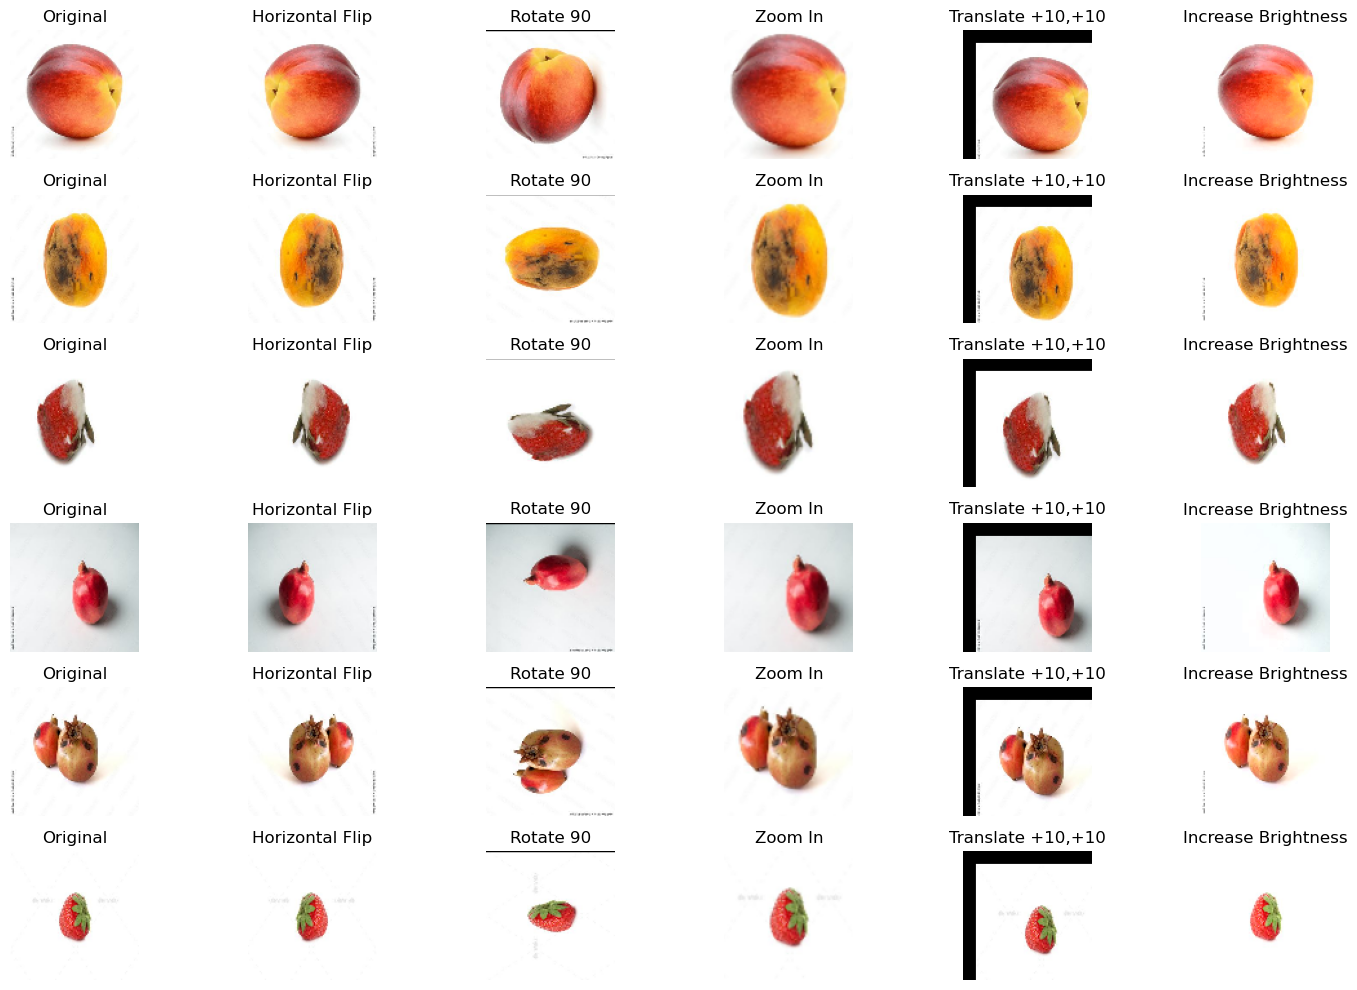

Jumlah Data Sebelum Augmentasi: 600
Jumlah Data Setelah Augmentasi: 3600


In [12]:
def plot_augmented_samples(data, labels, num_samples=1):
    sample_indices = {label: [] for label in set(labels)}
    
    for idx, label in enumerate(labels):
        if len(sample_indices[label]) < num_samples * 6:  # 1 original + 5 augmentations
            sample_indices[label].append(idx)
    
    fig, axes = plt.subplots(len(sample_indices), num_samples * 6, figsize=(15, 10))
    
    if len(sample_indices) == 1:
        axes = [axes]
    
    titles = ['Original', 'Horizontal Flip', 'Rotate 90', 'Zoom In', 'Translate +10,+10', 'Increase Brightness']
    for i, (label, indices) in enumerate(sample_indices.items()):
        for j in range(num_samples * 6):
            axes[i][j].imshow(data[indices[j]])
            axes[i][j].set_title(f"{titles[j % 6]}")
            axes[i][j].axis('off')
        
        axes[i][0].set_ylabel(label, rotation=90, size='large')
    
    plt.tight_layout()
    plt.show()

# Menampilkan gambar augmentasi
plot_augmented_samples(augmented_data, augmented_labels, num_samples=1)

print('Jumlah Data Sebelum Augmentasi:', len(data))
print('Jumlah Data Setelah Augmentasi:', len(augmented_data))

In [13]:
def angle(img, rotate):
    gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    max_val = np.max(gray_img)
    temp = np.zeros((max_val + 1, max_val + 1))

    if rotate == 0:
        temp[gray_img[:, :-1], gray_img[:, 1:]] += 1
    elif rotate == 45:
        temp[gray_img[:-1, 1:], gray_img[1:, :-1]] += 1
    elif rotate == 90:
        temp[gray_img[:-1, :], gray_img[1:, :]] += 1
    elif rotate == 135:
        temp[gray_img[:-1, :-1], gray_img[1:, 1:]] += 1

    data = temp + temp.T
    data /= np.sum(data)

    return data

def append(images):
    features = []
    rotates = [0, 45, 90, 135]

    for img in images:
        data = [angle(img, rotate) for rotate in rotates]
        features.append(data)

    return features

def countCsv(data):
    features = {}
    i_indices, j_indices = np.indices(data.shape)
    features['kontras'] = np.sum((i_indices - j_indices) ** 2 * data)
    features['dissimilarity'] = np.sum(np.abs(i_indices - j_indices) * data)
    features['homogenitas'] = np.sum(data / (1 + (i_indices - j_indices) ** 2))
    non_zero_elements = data[data > 0.0]
    features['entropy'] = -np.sum(non_zero_elements * np.log(non_zero_elements))
    features['energy'] = np.sum(data ** 2)
    features['asm'] = np.sum(data ** 2)
    features['korelasi'] = corellation(data)
    return features

def corellation(data):
    jumlahBaris, jumlahKolom = data.shape
    i_indices, j_indices = np.indices(data.shape)
    sumIJ = np.sum(i_indices * j_indices * data)
    sumI = np.sum(i_indices * data)
    sumJ = np.sum(j_indices * data)
    sumI_squared = np.sum((i_indices - sumI) ** 2 * data)
    sumJ_squared = np.sum((j_indices - sumJ) ** 2 * data)

    std_i = np.sqrt(sumI_squared)
    std_j = np.sqrt(sumJ_squared)

    if std_i != 0 and std_j != 0:
        kor = (sumIJ - sumI * sumJ) / (std_i * std_j)
    else:
        kor = 0

    return kor

def extract(data, label):
    features = append(data)
    rotates = ['0', '45', '90', '135']
    result = []
    n = 1000

    for j in tqdm(range(min(len(features), n)), desc=f'extract fitur untuk {label}'):
        eksfitur = [label]

        for i in features[j]:
            feature_values = countCsv(i)
            eksfitur.append(feature_values['kontras'])
            eksfitur.append(feature_values['dissimilarity'])
            eksfitur.append(feature_values['homogenitas'])
            eksfitur.append(feature_values['entropy'])
            eksfitur.append(feature_values['energy'])
            eksfitur.append(feature_values['asm'])
            eksfitur.append(feature_values['korelasi'])

        result.append(eksfitur)

    headers = ['path']
    for rotate in rotates:
        headers.extend([f'kontras{rotate}', f'dissimilarity{rotate}', f'homogenitas{rotate}', f'entropi{rotate}', f'asm{rotate}', f'energi{rotate}', f'correlation{rotate}'])

    df = pd.DataFrame(result, columns=headers)

    csv_path = f'csv tes/Before{label}.csv'
    df.to_csv(csv_path, index=False)
    return df

In [14]:
extract_f_peaches = extract([img for img, lbl in zip(data, labels) if lbl == 'fresh_peaches'], 'fresh_peaches')
extract_f_pomegranates = extract([img for img, lbl in zip(data, labels) if lbl == 'fresh_pomegranates'], 'fresh_pomegranates')
extract_f_strawberries = extract([img for img, lbl in zip(data, labels) if lbl == 'fresh_strawberries'], 'fresh_strawberries')
extract_r_peaches = extract([img for img, lbl in zip(data, labels) if lbl == 'rotten_peaches'], 'rotten_peaches')
extract_r_pomegranates = extract([img for img, lbl in zip(data, labels) if lbl == 'rotten_pomegranates'], 'rotten_pomegranates')
extract_r_strawberries = extract([img for img, lbl in zip(data, labels) if lbl == 'rotten_strawberries'], 'rotten_strawberries')

# Testing
print(extract_f_peaches.head())

extract fitur untuk rotten_strawberries: 100%|██████████| 100/100 [00:00<00:00, 255.15it/s]


            path    kontras0  dissimilarity0  homogenitas0  entropi0  \
0  fresh_peaches  450.181405       12.112356      0.121963  8.457464   
1  fresh_peaches  623.181433       13.972820      0.112815  8.274991   
2  fresh_peaches  646.703720       13.896626      0.116062  8.130217   
3  fresh_peaches  470.218276       11.876137      0.146181  8.153734   
4  fresh_peaches  766.528433       16.211434      0.097598  8.499548   

       asm0   energi0  correlation0    kontras45  dissimilarity45  ...  \
0  0.000225  0.000225      0.914880   692.371183        15.315103  ...   
1  0.000270  0.000270      0.818771   710.780544        15.830003  ...   
2  0.000313  0.000313      0.813938   933.646675        18.169727  ...   
3  0.000305  0.000305      0.928122   812.728840        17.155956  ...   
4  0.000216  0.000216      0.864139  1357.335473        22.351382  ...   

      asm90  energi90  correlation90   kontras135  dissimilarity135  \
0  0.000211  0.000211       0.909950   612.917690  

In [15]:
def seleksi(dataframe, threshold=0.5):
    numdata = dataframe.drop(columns=['path'])
    corelasi = numdata.corr().abs()
    upper = corelasi.where(np.triu(np.ones(corelasi.shape), k=1).astype(bool))
    kedrop = [column for column in upper.columns if any(upper[column] > threshold)]
    return dataframe.drop(kedrop, axis=1)


dataframes = [extract_f_peaches, extract_f_pomegranates, extract_f_strawberries, extract_r_peaches, extract_r_pomegranates, extract_r_strawberries]
fruit1, fruit2, fruit3, fruit4, fruit5, fruit6 = map(seleksi, dataframes)

print([fruit1, fruit2, fruit3, fruit4, fruit5, fruit6])

[             path     kontras0  entropi0
0   fresh_peaches   450.181405  8.457464
1   fresh_peaches   623.181433  8.274991
2   fresh_peaches   646.703720  8.130217
3   fresh_peaches   470.218276  8.153734
4   fresh_peaches   766.528433  8.499548
..            ...          ...       ...
95  fresh_peaches  1286.192111  7.721570
96  fresh_peaches   713.132296  8.255952
97  fresh_peaches  1581.477946  8.452292
98  fresh_peaches   891.664662  8.122826
99  fresh_peaches   643.921856  8.467620

[100 rows x 3 columns],                   path     kontras0
0   fresh_pomegranates   705.502209
1   fresh_pomegranates   592.917626
2   fresh_pomegranates  1004.342044
3   fresh_pomegranates   897.965497
4   fresh_pomegranates   927.549196
..                 ...          ...
95  fresh_pomegranates   653.995461
96  fresh_pomegranates   418.433167
97  fresh_pomegranates   833.886153
98  fresh_pomegranates   558.991018
99  fresh_pomegranates   966.001248

[100 rows x 2 columns],                   path   

In [16]:
def split_data(X, y, test_size=0.3, random_state=None):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Dataframe untuk augmentasi data
all_data = pd.DataFrame({'image_path': img_paths, 'label': augmented_labels})

X = all_data['image_path'].values
y = all_data['label'].values

# Split data
train_test_ratio = 0.8
test_size = 1 - train_test_ratio

X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

print("Jumlah data training:", len(X_train))
print("Jumlah data testing:", len(X_test))

Jumlah data training: 2880
Jumlah data testing: 720


In [17]:
def save_images_to_folder(image_paths, labels, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_folder = os.path.join(folder_name, label)
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

    for img_path, label in zip(image_paths, labels):
        label_folder = os.path.join(folder_name, label)
        shutil.copy(img_path, label_folder)

# Simpan data training dan testing ke folder
save_images_to_folder(X_train, y_train, 'data_train')
save_images_to_folder(X_test, y_test, 'data_test')

print("Data berhasil disimpan ke folder 'data_train' dan 'data_test'")

Data berhasil disimpan ke folder 'data_train' dan 'data_test'


In [18]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train_images = np.array([cv.imread(path) for path in X_train])
X_test_images = np.array([cv.imread(path) for path in X_test])

# Flatten the images
X_train_flatten = X_train_images.reshape(X_train_images.shape[0], -1)
X_test_flatten = X_test_images.reshape(X_test_images.shape[0], -1)

# Impute and scale
XTrainImputed = imputer.fit_transform(X_train_flatten)
XTestImputed = imputer.transform(X_test_flatten)
XTrainNorm = scaler.fit_transform(XTrainImputed)
XTestNorm = scaler.transform(XTestImputed)

In [19]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(XTrainNorm, y_train)
y_pred_knn = knn_model.predict(XTestNorm)

svc_model = SVC()
svc_model.fit(XTrainNorm, y_train)
y_pred_svc = svc_model.predict(XTestNorm)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(XTrainNorm, y_train)
y_pred_rf = rf_model.predict(XTestNorm)
# time: 2m

In [20]:
all_labels = np.unique(np.concatenate((y_train, y_test)))

# Evaluasi dan Tampilan Hasil
def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

# Evaluasi model
akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)

print(f"Akurasi KNN : {akurasiknn * 100:.2f}%")
print(f"Akurasi SVC  : {akurasisvc * 100:.2f}%")
print(f"Akurasi RF  : {akurasirf * 100:.2f}%")

Akurasi KNN : 55.14%
Akurasi SVC  : 65.69%
Akurasi RF  : 70.28%


 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.55138889 │ 0.58176689 │ 0.55138889 │ 0.54423872 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.65694444 │ 0.68269657 │ 0.65694444 │ 0.65552965 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.70277778 │ 0.70566862 │ 0.70277778 │ 0.70083821 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


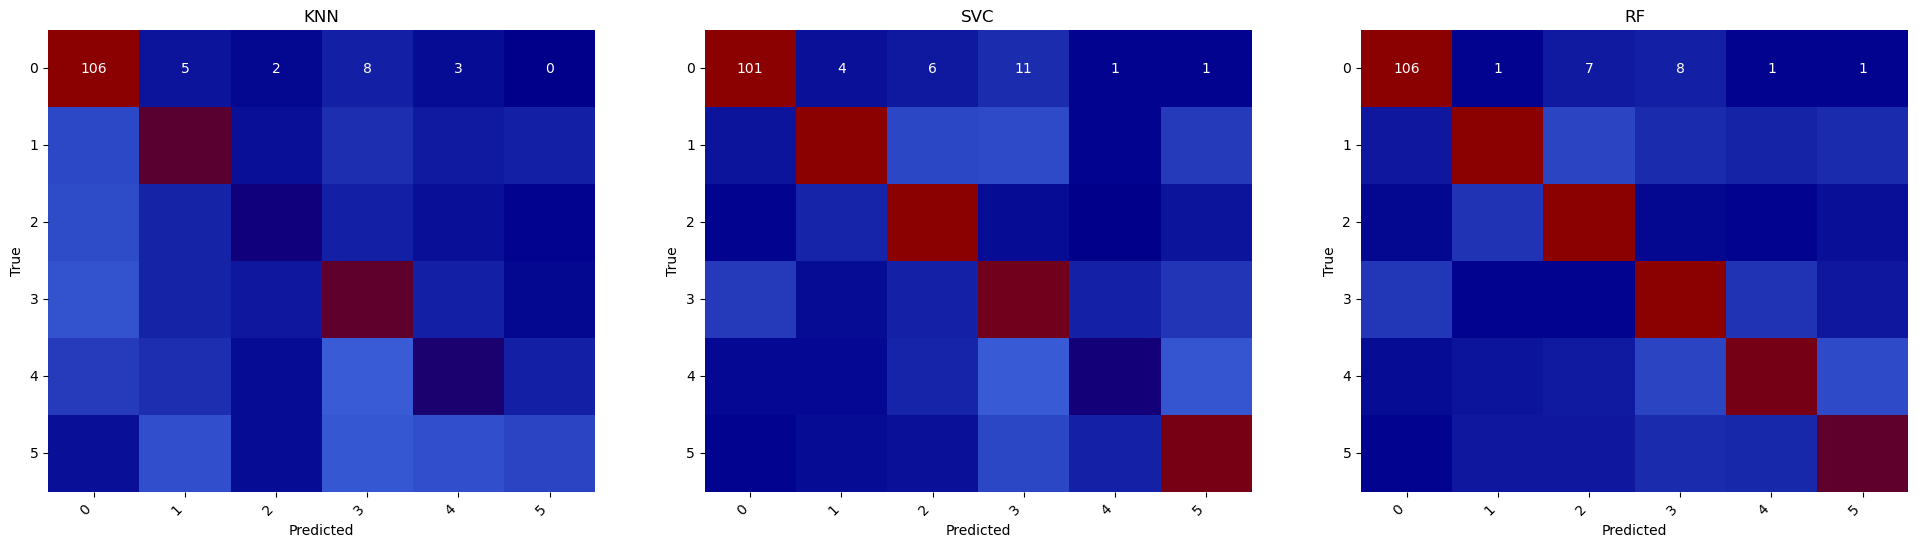

In [21]:
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

colors = ["#00008B", "#4169E1", "#00008B", "#8B0000", "#8B0000"]
cmap = LinearSegmentedColormap.from_list("color", colors, N=256)

plt.figure(figsize=(24, 6), facecolor='None')

plt.subplot(1, 3, 1)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_knn), fmt='d', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 2)
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_svc), fmt='d', cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 3)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_rf), fmt='d', cbar=False)
plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

Epoch 1/20


c:\Users\LEGION\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.2919 - loss: 1.6758 - val_accuracy: 0.5250 - val_loss: 1.2043
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.5451 - loss: 1.1787 - val_accuracy: 0.6597 - val_loss: 0.9089
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6396 - loss: 0.9557 - val_accuracy: 0.6597 - val_loss: 0.8993
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6990 - loss: 0.7893 - val_accuracy: 0.7875 - val_loss: 0.5664
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7655 - loss: 0.6128 - val_accuracy: 0.7736 - val_loss: 0.5941
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7917 - loss: 0.5776 - val_accuracy: 0.8139 - val_loss: 0.4682
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8358 - loss: 0.4764 - val_accuracy: 0.8292 - val_loss: 0.4582
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8454 - loss: 0.4210 - val_accuracy: 0.8167 - val_loss: 0.

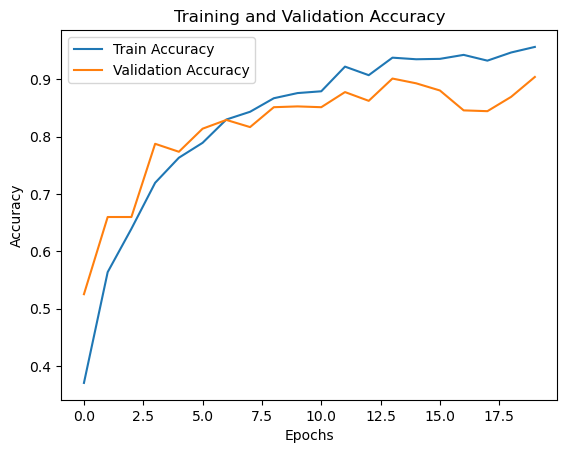

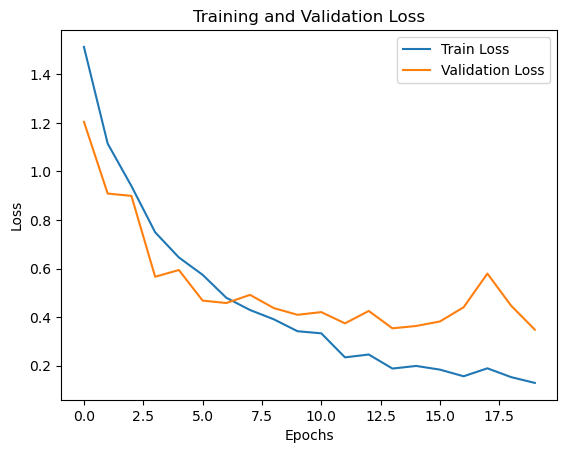

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Konversi label ke format one-hot encoding
def preprocess_labels(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_one_hot = to_categorical(labels_encoded)
    return labels_one_hot, label_encoder

# Fungsi untuk membuat model CNN
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Fungsi untuk melatih model CNN
def train_cnn_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    return history

# Fungsi untuk mengevaluasi model CNN
def evaluate_cnn_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    return test_loss, test_accuracy

# Preprocess labels
y_train_one_hot, label_encoder = preprocess_labels(y_train)
y_test_one_hot, _ = preprocess_labels(y_test)

# Mengubah data gambar menjadi float dan normalisasi
X_train_images = np.array([cv.imread(path) for path in X_train]).astype('float32') / 255.0
X_test_images = np.array([cv.imread(path) for path in X_test]).astype('float32') / 255.0

# Mendefinisikan input shape
input_shape = X_train_images.shape[1:]
num_classes = y_train_one_hot.shape[1]

# Membuat dan melatih model CNN
cnn_model = create_cnn_model(input_shape, num_classes)
history = train_cnn_model(cnn_model, X_train_images, y_train_one_hot, X_test_images, y_test_one_hot, epochs=20, batch_size=32)

# Mengevaluasi model CNN
test_loss, test_accuracy = evaluate_cnn_model(cnn_model, X_test_images, y_test_one_hot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot history training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |CNN       │ 0.90416667 │ 0.90546980 │ 0.90416667 │ 0.90446510 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


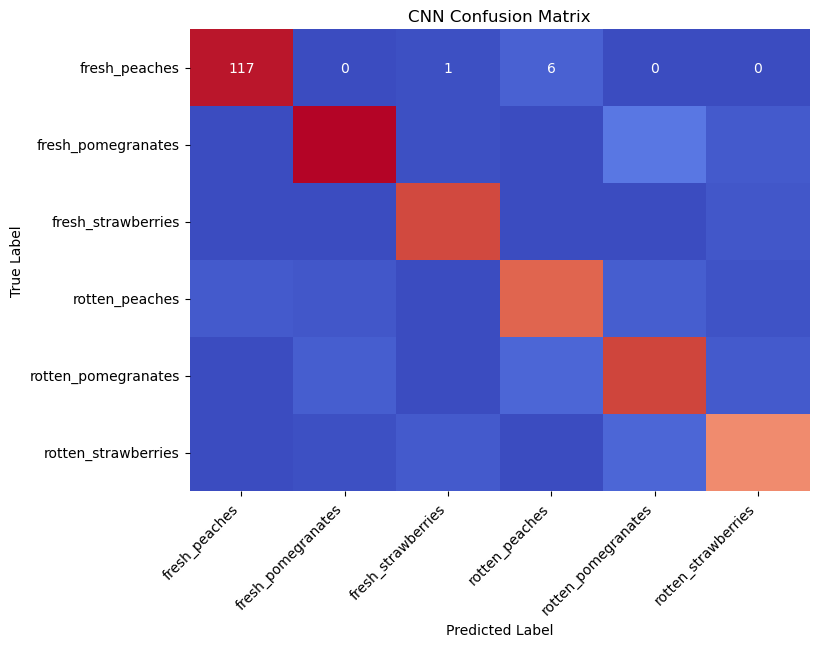

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Prediksi menggunakan model CNN
y_pred_cnn = cnn_model.predict(X_test_images)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Evaluasi metrik untuk CNN
accuracy_cnn = accuracy_score(y_true_classes, y_pred_cnn_classes)
precision_cnn = precision_score(y_true_classes, y_pred_cnn_classes, average='weighted')
recall_cnn = recall_score(y_true_classes, y_pred_cnn_classes, average='weighted')
f1_cnn = f1_score(y_true_classes, y_pred_cnn_classes, average='weighted')

# Confusion Matrix untuk CNN
cm_cnn = confusion_matrix(y_true_classes, y_pred_cnn_classes)

# Nama label
labels = label_encoder.classes_

# Header tabel
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_cnn = f"{' |CNN':<10}  │ {accuracy_cnn:<10.8f} │ {precision_cnn:<10.8f} │ {recall_cnn:<10.8f} │ {f1_cnn:<10.8f} |"

# Print tabel metrik evaluasi
print(top_border)
print(header)
print(mid_border)
print(row_cnn)
print(bottom_border)

# Warna untuk heatmap
colors = ["#00008B", "#4169E1", "#00008B", "#8B0000", "#8B0000"]
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6), facecolor='None')

sns.heatmap(cm_cnn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_cnn), fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()


In [24]:
def resize_image(image, width, height):
    return cv.resize(image, (width, height))

# Fungsi untuk mengubah gambar menjadi grayscale
def convert_to_grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Fungsi untuk spesifikasi histogram
def histogram_specification(image, reference):
    hist, bins = np.histogram(reference.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf_image = hist.cumsum()
    cdf_image_normalized = cdf_image * hist.max() / hist.max()
    
    cdf_image_normalized = np.ma.masked_equal(cdf_image_normalized, 0)
    cdf_image_normalized = (cdf_image_normalized - cdf_image_normalized.min()) * 255 / (cdf_image_normalized.max() - cdf_image_normalized.min())
    cdf_image_normalized = np.ma.filled(cdf_image_normalized, 0).astype('uint8')
    
    image2 = cdf_image_normalized[image]
    return image2

# Fungsi untuk ekualisasi histogram
def histogram_equalization(image):
    if len(image.shape) == 2:  # Grayscale image
        return cv.equalizeHist(image)
    else:  # Color image
        ycrcb = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv.equalizeHist(ycrcb[:, :, 0])
        return cv.cvtColor(ycrcb, cv.COLOR_YCrCb2BGR)

# Fungsi untuk deteksi tepi menggunakan Canny
def edge_detection(image, low_threshold, high_threshold):
    return cv.Canny(image, low_threshold, high_threshold)


In [25]:
image_directory = 'augmented_images'

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_directory, filename)

        image = cv.imread(image_path)
        resized_image = resize_image(image, 300, 300)
        grayscale_image = convert_to_grayscale(resized_image)
        equalized_image = histogram_equalization(grayscale_image)
        edges = edge_detection(grayscale_image, 50, 150)
        
print("Proses preprocessing selesai.")

Proses preprocessing selesai.


Akurasi KNN : 31.11%
Akurasi SVC  : 39.72%
Akurasi RF  : 43.75%
 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.31111111 │ 0.36740504 │ 0.31111111 │ 0.29223416 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.39722222 │ 0.40224645 │ 0.39722222 │ 0.39882902 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.43750000 │ 0.43404867 │ 0.43750000 │ 0.43274657 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


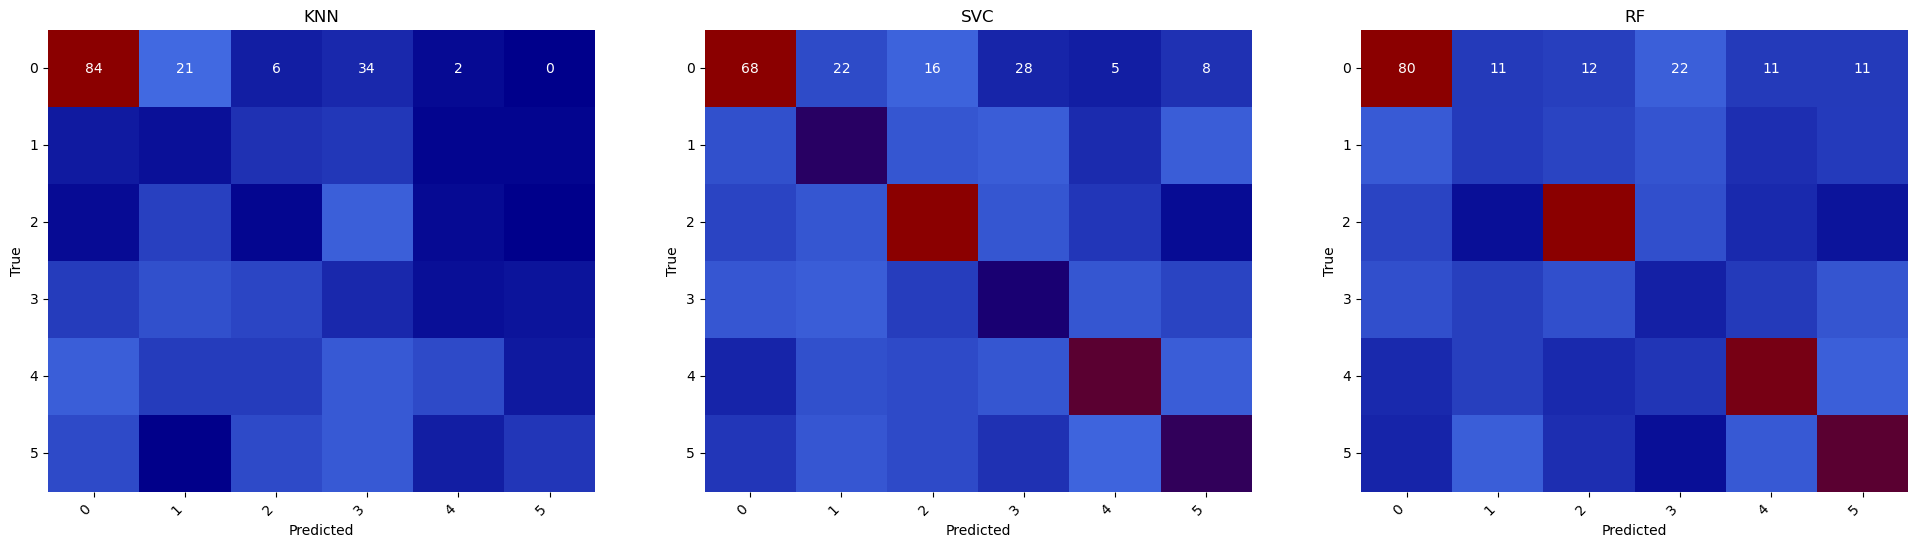

In [28]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Fungsi untuk preprocess gambar
def resize_image(image, width, height):
    return cv.resize(image, (width, height))

def convert_to_grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

def histogram_equalization(image):
    return cv.equalizeHist(image)

def thresholding(image):
    _, thresh_image = cv.threshold(image, 128, 255, cv.THRESH_BINARY)
    return thresh_image

def edge_detection(image, low_threshold, high_threshold):
    return cv.Canny(image, low_threshold, high_threshold)

def find_contours(image):
    contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours

# Fungsi untuk ekstraksi fitur HOG
def extract_hog_features(image):
    fd, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return fd

# Path ke direktori gambar dan label
image_directory = 'augmented_images'
labels = []  # Label gambar
features = []  # Fitur gambar

# Memeriksa apakah direktori gambar ada
if not os.path.exists(image_directory):
    print("Direktori gambar tidak ditemukan.")
else:
    # Loop melalui subfolder dalam direktori
    for subfolder in os.listdir(image_directory):
        subfolder_path = os.path.join(image_directory, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    image_path = os.path.join(subfolder_path, filename)
                    
                    # Membaca gambar
                    image = cv.imread(image_path)
                    
                    # Resize gambar
                    resized_image = resize_image(image, 300, 300)
                    
                    # Mengubah gambar menjadi grayscale
                    grayscale_image = convert_to_grayscale(resized_image)
                    
                    # Ekualisasi histogram
                    equalized_image = histogram_equalization(grayscale_image)
                    
                    # Thresholding
                    thresh_image = thresholding(equalized_image)
                    
                    # Deteksi tepi
                    edges = edge_detection(thresh_image, 50, 150)
                    
                    # Menemukan kontur
                    contours = find_contours(edges)
                    
                    # Menggambar kontur pada gambar asli (opsional)
                    # cv.drawContours(resized_image, contours, -1, (0, 255, 0), 2)
                    
                    # Ekstraksi fitur menggunakan HOG
                    hog_features = extract_hog_features(edges)
                    
                    # Menyimpan fitur dan label
                    features.append(hog_features)
                    labels.append(subfolder)  # Label diambil dari nama subfolder

# Konversi fitur dan label ke numpy array
features = np.array(features)
labels = np.array(labels)

# Pembagian dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Inisialisasi scaler dan imputer
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

# Imputasi dan normalisasi data
XTrainImputed = imputer.fit_transform(X_train)
XTestImputed = imputer.transform(X_test)
XTrainNorm = scaler.fit_transform(XTrainImputed)
XTestNorm = scaler.transform(XTestImputed)

# Inisialisasi model
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='linear')
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Pelatihan model
knn.fit(XTrainNorm, y_train)
svc.fit(XTrainNorm, y_train)
rf.fit(XTrainNorm, y_train)

# Prediksi menggunakan model yang sudah dilatih
y_pred_knn = knn.predict(XTestNorm)
y_pred_svc = svc.predict(XTestNorm)
y_pred_rf = rf.predict(XTestNorm)

# Fungsi evaluasi
def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

# Evaluasi model
akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)

print(f"Akurasi KNN : {akurasiknn * 100:.2f}%")
print(f"Akurasi SVC  : {akurasisvc * 100:.2f}%")
print(f"Akurasi RF  : {akurasirf * 100:.2f}%")

# Tabel hasil evaluasi
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62
top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

# Visualisasi matriks kebingungan
colors = ["#00008B", "#4169E1", "#00008B", "#8B0000", "#8B0000"]
cmap = LinearSegmentedColormap.from_list("color", colors, N=256)

plt.figure(figsize=(24, 6), facecolor='None')

plt.subplot(1, 3, 1)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_knn), fmt='d', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 2)
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_svc), fmt='d', cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 3)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_rf), fmt='d', cbar=False)
plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()
